In [1]:
import pytorch_lightning as pl
import pytorch_lightning.callbacks as pl_callbacks
import torch
import numpy as np
import matplotlib.pyplot as plt

import eq

## Loading the catalog

By default, all catalogs are saved to the following directory

In [2]:
print(eq.data.default_catalogs_dir)

/Users/kdascher/Documents/recast_test/recast/data


In [3]:
# !rm -rf /Users/kdascher/Documents/recast_test/recast/data/ANSS_MultiCatalog
catalog = eq.catalogs.ANSS_MultiCatalog(    
    num_sequences=1000,
    t_end_days=1*365,
    mag_completeness=4.5,
    minimum_mainshock_mag=6.5,
)

Loading existing catalog from /Users/kdascher/Documents/recast_test/recast/data/ANSS_MultiCatalog.


Other available catalogs:
- `eq.catalogs.SCEDC`
- `eq.catalogs.QTMSanJacinto`
- `eq.catalogs.QTMSaltonSea`
- `eq.catalogs.QTMSaltonSea`

### Representing the data
We can represent all data stored in the catalog as an object of type `eq.data.Sequence`.

In [4]:
catalog.train

InMemoryDataset(600)

An `eq.data.Sequence` object contains the following attributes:
- `t_start` and `t_end`: Start and end of the time interval containing the events (in days).
- `arrival_times`: Arrival times of each event (in days), shape `[num_events]`
- `inter_times`: Inter-event times, shape `[num_events + 1]` since this also includes the last survival time from `arrival_times[-1]` until `t_end`.
- `mag`: Magnitude of each earthquake, shape `[num_events]`.
- `t_nll_start`: This attributed allows to compute the negative log-likelihood (NLL) only for the observations in the interval `[t_nll_start, t_end]`, while conditioning the model on past events in `[t_start, t_nll_start]`.

<Axes: xlabel='Arrival time (days)', ylabel='Magnitude'>

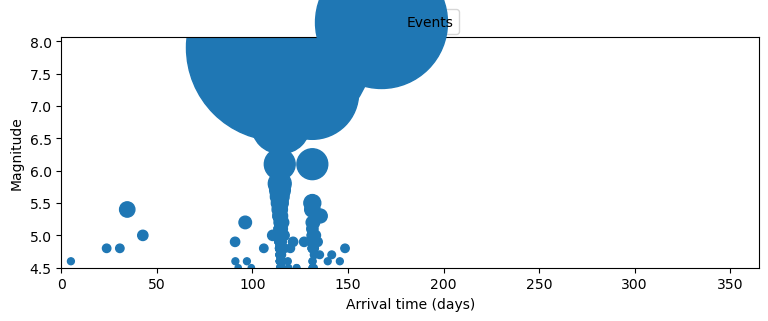

In [5]:
eq.visualization.visualize_sequence(catalog.test[100])

### Train / val / test split

To compare different models, we split the full event sequence into 3 components:
- `train`: used for training the models, includes events between `2008-01-01` and `2014-01-01`.
- `val`: used for early stopping and hyperparameter selection, includes events between `2014-01-01` and `2017-01-01`.
- `test`: used for final evaluation, includes events between `2017-01-01` and `2021-01-01`.

We already provided the start of the val and test intervals when loading the catalog, so now the train, val and test sequences are stored in `catalog.train`, `catalog.val` and `catalog.test`, respectively.

In our case the catalog consists of a single event sequence but, in principle, there could be multiple event sequences stored in `catalog.train`, `catalog.val` and `catalog.test`.

In [6]:
print("Train sequence:")
print(catalog.train[0])
print("\nValidation sequence:")
print(catalog.val[0])
print("\nTest sequence:")
print(catalog.test[0])

Train sequence:
Sequence(
  inter_times: [114],
  arrival_times: [113],
  t_start: 0.0,
  t_end: 365.0,
  t_nll_start: 0.0,
  mag: [113]
)

Validation sequence:
Sequence(
  inter_times: [490],
  arrival_times: [489],
  t_start: 0.0,
  t_end: 365.0,
  t_nll_start: 0.0,
  mag: [489]
)

Test sequence:
Sequence(
  inter_times: [132],
  arrival_times: [131],
  t_start: 0.0,
  t_end: 365.0,
  t_nll_start: 0.0,
  mag: [131]
)


Note that, for example, the `test` sequence contains all events in the catalog, including the training set.

However, since we specified `t_nll_start`, the model will know to only compute the NLL on the interval `[t_nll_start, t_end]` (shown in orange in the figure below), while also conditioning on the events from `[0, t_nll_start]`.

<Axes: xlabel='Arrival time (days)', ylabel='Magnitude'>

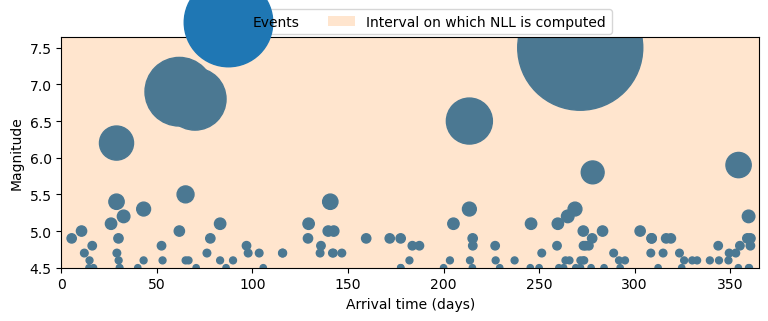

In [7]:
eq.visualization.visualize_sequence(catalog.test[0], show_nll=True)

## Training the model

We will train the model using the high-level API provided by `pytorch_lightning`.

For this, we first need to create `torch.utils.data.DataLoader` objects that will feed the data into the model.

In [8]:
dl_train = catalog.train.get_dataloader(batch_size=200, shuffle=True)
dl_val = catalog.val.get_dataloader(batch_size=200)
dl_test = catalog.test.get_dataloader()

## Two ways of training the models:

In [9]:
T = catalog.train[0].t_end
N = np.mean([len(seq) for seq in catalog.train])
mag_mean = np.mean([catalog.train[0].mag.mean().item() for seq in catalog.train])
tau_mean = T/N

model = eq.models.RecurrentTPP(
    mag_mean = mag_mean,
    tau_mean = tau_mean,
    mag_completeness=catalog.metadata['mag_completeness'],
    learning_rate=1e-3,
)

In [ ]:
epochs = 100
running_training_loss = []
running_validation_loss = []
optimizer = torch.optim.Adam(model.parameters(), lr=3e-3) 

for _ in range(epochs):
    epoch_loss = []
    for train_batch in dl_train:
        optimizer.zero_grad()                           # zero the gradient buffers
        nll = model.nll_loss(train_batch).sum()         # compute the loss
        nll.backward()                                  # compute the gradients
        optimizer.step()                                # update the weights
        epoch_loss.append(nll.item())                   # save the training loss
    running_training_loss.append(sum(epoch_loss))
    with torch.no_grad():                               # compute/save the validation loss
        nll_val = model.nll_loss(next(iter(dl_val))).sum()
        running_validation_loss.append(nll_val.item())       

fig, ax = plt.subplots()
ax.plot(running_training_loss, label="Training loss")
ax.plot(running_validation_loss, label="Validation loss")
ax.legend()
ax.set(
    xlabel="Epoch",
    ylabel="NLL per unit time", 
);

In [11]:
T = catalog.train[0].t_end
N = np.mean([len(seq) for seq in catalog.train])
mag_mean = np.mean([catalog.train[0].mag.mean().item() for seq in catalog.train])
tau_mean = T/N

model = eq.models.RecurrentTPP(
    mag_mean = mag_mean,
    tau_mean = tau_mean,
    mag_completeness=catalog.metadata['mag_completeness'],
    learning_rate=1e-3,
)

`pytorch_lightning.Trainer` takes care of training the model, early stopping and saving the best weights.

In [12]:
# ModelCheckpoints saves the model with the best validation loss
checkpoint = pl_callbacks.ModelCheckpoint(monitor="total_val_loss")

# EarlyStopping stops training if the validation loss doesn't improve by more than 1e-3 for 20 epochs
early_stopping = pl_callbacks.EarlyStopping(monitor="total_val_loss", patience=2, min_delta=1e-3)

# Trainer set up training and validation loops with previous specs
trainer = pl.Trainer(max_epochs=10, callbacks=[checkpoint, early_stopping],log_every_n_steps=1)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/kdascher/miniforge3/envs/eq/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(


In [ ]:
trainer.fit(model, dl_train, dl_val)

## Evaluation

Load the model with the best validation loss

In [ ]:
print(checkpoint.best_model_path)

/auto/home/kdascher/Documents/UCSC/projects/TPP/MAG_RECAST/recast/notebooks/exploratory_notebooks/multicatalog_forecasts/lightning_logs/version_19/checkpoints/epoch=199-step=2399.ckpt


In [ ]:
model.load_from_checkpoint(checkpoint.best_model_path)

RecurrentTPP(
  (hypernet_time): Linear(in_features=32, out_features=96, bias=True)
  (hypernet_mag): Linear(in_features=32, out_features=1, bias=True)
  (rnn): GRU(2, 32, batch_first=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

After training the model, we compute the loss on the negative log-likelihood (NLL) loss on the test set.

In [ ]:
trainer.test(model, dl_test)

/Users/kdascher/miniforge3/envs/eq/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

In [ ]:
trainer.test(model, dl_val)